In [1]:
import sys
import warnings
import matplotlib 

sys.path.append('..')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import timedelta
from scipy.stats import beta

sns.set_style("whitegrid")

plt.rc("text", usetex=True)
plt.rc("font", family="serif")
matplotlib.rcParams["text.latex.preamble"] = [r"\usepackage{amsmath}"]

## Data

COVID-19 positive test counts (`Daily lab-confirmed cases`) by Lower tier local authority (LTLA) as reported on a given date for all preceding test dates (`Specimen date`).

In [2]:
ltla = "Thurrock"
report_dt = "2020-12-14"

In [3]:
df = pd.read_csv(f"../data/cases-{report_dt}.csv"
                ).query(f"`Area name` == '{ltla}' & `Area type` == 'ltla'")
df = df.sort_values('Specimen date')

We model the last two weeks of data. 

In [4]:
ys_sequence = df['Daily lab-confirmed cases'].values[-14:]
specimen_dates = df['Specimen date'].unique()[-14:]

The dashed line in the plot below indicates that counts for the most recent dates do not reflect the final count yet and are subject to change in future reports due to the lag in reporting (it takes about 4 days for all tests to be processed and positive test counts reported).

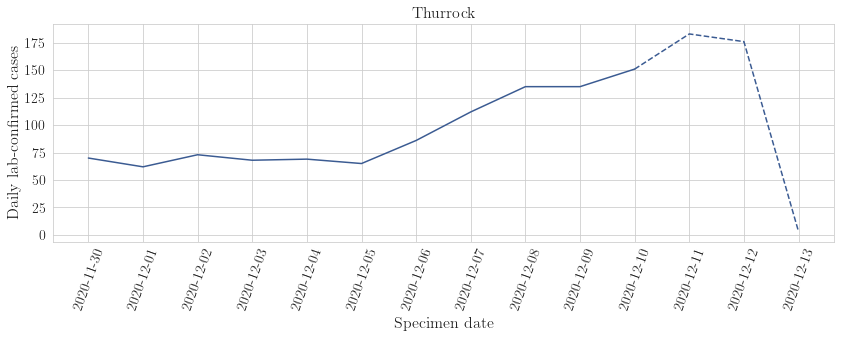

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(14,4))

plt.plot(specimen_dates[:-3], ys_sequence[:-3], "xkcd:denim blue")
plt.plot(specimen_dates[-4:], ys_sequence[-4:], color="xkcd:denim blue", linestyle="--")

plt.title(f"{ltla}", fontsize=16)
plt.ylabel('Daily lab-confirmed cases', fontsize=16)
plt.xlabel('Specimen date', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=70)

plt.show()

## Reporting priors ($\theta_j$)

A core assumption of the model is that the reporting lag is consistent and predictable. We load two weeks of prior reports to learn the most recent reporting behaviour (i.e., what proportion of final count is usually reported at each lag). Helper functions are provided to do this.

In [4]:
from data_processing.data import get_data, moment_match_theta_priors

In [7]:
last_report_dt = pd.to_datetime(report_dt)
report_dates = pd.date_range(start=last_report_dt - timedelta(14), end=last_report_dt)

historical_df = get_data(ltla, report_dates=report_dates)

For a given`Specimen date` we have the proportion of the final count reported (`prop_reported`) at each `lag` $j$. `Lag` is the difference in days between `Specimen date` and `Report date`. 

In [28]:
historical_df[['Specimen date', 'Report date', 'Daily lab-confirmed cases', 'prop_reported', 'lag']
             ].sort_values(['Specimen date','Report date']).head()

,Specimen date,Report date,Daily lab-confirmed cases,prop_reported,lag
0,2020-11-25,2020-11-30,64,0.969697,5
1,2020-11-25,2020-12-01,65,0.984848,6
2,2020-11-25,2020-12-02,66,1.000000,7
3,2020-11-25,2020-12-03,66,1.000000,8
4,2020-11-25,2020-12-04,66,1.000000,9


For each lag $j$ we get the mean and the variance of the reporting proportions from the data. We then use moment matching to get the $\alpha_j$ and $\beta_j$ shape parameters of the Beta prior. 

In [9]:
alphas, betas = moment_match_theta_priors(historical_df, n_lags=len(ys_sequence))

Below we plot the historical reporting proportions and the corresponding prior on the $\theta_j$ parameter for the first 5 lags. The data and priors show that by lag 4 the full count is usually reported.

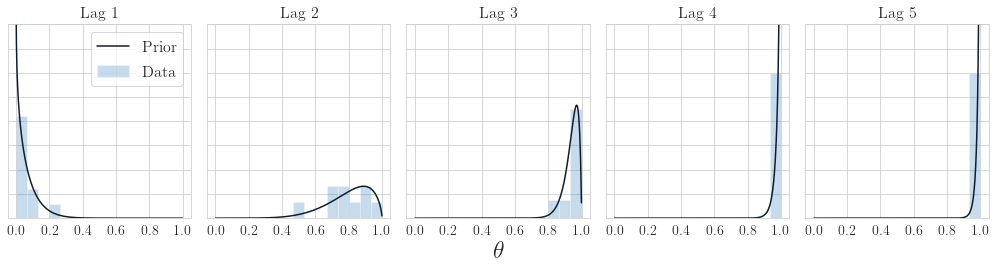

In [10]:
fig, ax = plt.subplots(1, 5, figsize=(14, 4))
x = np.linspace(0, 1, 1002)[1:-1]

for i in range(1, 6):
    curr_ax = ax[i-1]
    
    empirical = historical_df[historical_df['lag']==i][:-4]
    curr_ax.hist(empirical['prop_reported'], range=(0,1), bins=15, label='Data', alpha=0.25, density=True)

    dist = beta(alphas[-i], betas[-i])
    curr_ax.plot(x, dist.pdf(x), label='Prior', color="#0e1c2e")

    curr_ax.set_ylim(0,20)

    if i == 0:
        curr_ax.set_ylabel(f"{l}", fontsize=16)
    curr_ax.set_yticklabels([])

    curr_ax.set_title(f"Lag {i}", fontsize=16)

    if i==3:
        curr_ax.set_xlabel(r'$\theta$', fontsize=24)

    plt.setp(curr_ax.get_xticklabels(), fontsize=14)
    plt.setp(curr_ax.get_yticklabels(), fontsize=14)
    
ax[0].legend(fontsize=16)
plt.suptitle(f"", fontsize=16)
plt.tight_layout() 

## Model

In [109]:
from models import Nowcaster

To instantiate the model we have to specify the reporting priors. This we got from data in the above step. Additionally, we have to specify the random walk scale on the AR1 prior. In practice we would run the model with a number of different random walk scales and choose the model with the scale that maximises the model evidence.

In [12]:
model = Nowcaster(
            random_walk_scale=4,
            prior_theta_shape_a = alphas,
            prior_theta_shape_b = betas
)

Once the model class is instantiated, we just pass the reported counts and dates to the `model.fit()` method. The dates are included to allow the model to account for weekend effects.

In [13]:
model.fit(
    observations=ys_sequence,
    dates=specimen_dates
)

## Model outputs

The model class comes with methods to access and plot the model outputs.

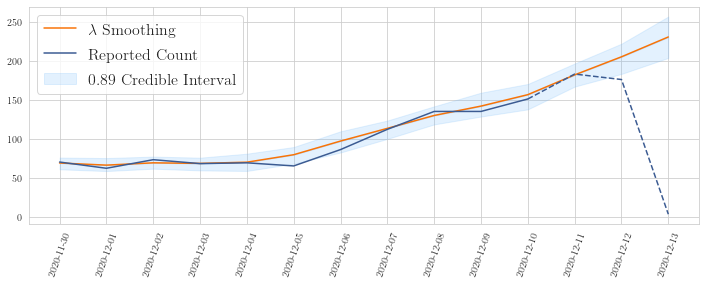

In [14]:
model.plot_lambda_smoothing()

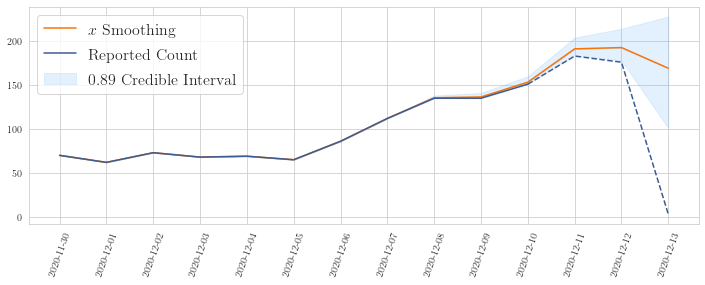

In [15]:
model.plot_x_smoothing()

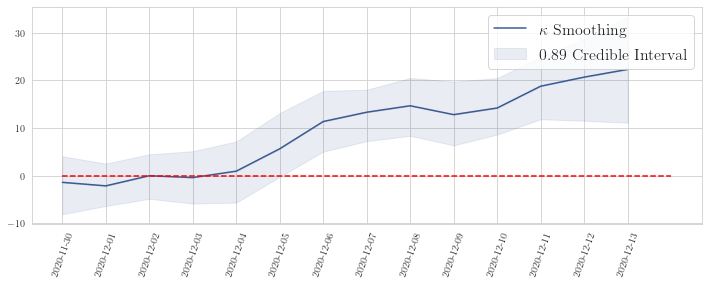

In [16]:
model.plot_drift_smoothing()

One can also directly access the samples plotted above by calling the below model properties:

- `model.lambda_smoothing_samples`
- `model.x_smoothing_samples`
- `model.kappa_smoothing_samples`

In [17]:
[x.mean() for x in model.x_smoothing_samples]

[70.02,
 62.007,
 73.0,
 68.008,
 69.001,
 65.003,
 86.0,
 112.004,
 135.54,
 136.462,
 153.298,
 191.199,
 192.677,
 169.15]

Lastly, we can get the model evidence.

In [18]:
sum(model.log_evidence)

-2136.3867602565024

In [9]:
from data_processing.data import create_profiles

In [110]:
import pickle

In [166]:
df = pd.read_csv(f"../data/cases-2020-12-14.csv")
all_ltlas = df.query("`Area type` == 'ltla'")['Area name'].unique()

In [167]:
len(all_ltlas)

315

In [168]:
for ltla in all_ltlas:
    save_name = ltla.replace(" ", "_")
    with open(f'../../ltla-covid-cases/data/pickles/drift_model_repro_check_scale_4/2020-12-14/{save_name}.pickle', 'rb') as f:
        model = pickle.load(f)
    with open(f'../../ltla-covid-cases/data/pickles/drift_model_refactored_scale_4/2020-12-14/{save_name}.pickle', 'rb') as f:
        model2 = pickle.load(f)
    test = [lam.mean() for lam in model.lambda_smoothing_samples] == [lam.mean() for lam in model2.lambda_smoothing_samples]
    check = [x.mean() for x in model.x_smoothing_samples] == [x.mean() for x in model2.x_smoothing_samples]
    ev = sum(model.log_evidence) == sum(model2.log_evidence)
    if test == False or check == False or ev == False:
        print(ltla)
    print('ok')

ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
